# Example 5a: Ultra-thin GaAs cell with diffraction grating

In previous examples, we have considered a few different methods used to improve absorption in solar cells:
anti-reflection coatings, to decrease front-surface reflection, metallic rear mirrors to reduce transmission and increase
the path length of light in the cell, and textured surfaces (with pyramids) which are used on Si cells to reduce
reflection and increase the path length of light in the cell. Another method which can be used for light-trapping is the
inclusion of periodic structures such as diffraction gratings or photonic crystals; here, we will consider an ultra-thin
(80 nm) GaAs cell with a diffraction grating.

This example is based on the simulations done for [this paper](https://doi.org/10.1002/pip.3463).

*Note:* This example requires that you have a [working S4 installation](https://rayflare.readthedocs.io/en/latest/Installation/installation.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from solcore import si, material
from solcore.structure import Layer
from solcore.light_source import LightSource
from solcore.solar_cell import SolarCell
from solcore.constants import q
from solcore.absorption_calculator import search_db

from rayflare.rigorous_coupled_wave_analysis.rcwa import rcwa_structure
from rayflare.transfer_matrix_method.tmm import tmm_structure
from rayflare.options import default_options

## Setting up

First, defining all the materials. We are just going to do an optical simulation, so don't have to worry about doping levels
and other parameters which would affect the electrical performance of the cell.

In [2]:
InAlP = material('AlInP')(Al=0.5)  # In0.5Al0.5P
GaAs = material('GaAs')()
InGaP = material('GaInP')(In=0.5)  # Ga0.5In0.5P
SiN = material('Si3N4')()     # for the ARC
Al2O3 = material('Al2O3P')()  # for the ARC

Air = material('Air')()

The optical constants used for the silver are [very important](https://doi.org/10.1016/j.solmat.2018.11.008), so we search for a known reliable dataset (from [this paper](https://doi.org/10.1038/srep30605)).

In [3]:
Ag_pageid = search_db(os.path.join("Ag", "Jiang"))[0][0]
Ag = material(str(Ag_pageid), nk_db=True)()

Database file found at /Users/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
2	main	Ag	Jiang	main/Ag/Jiang.yml	1	1	0.3	2.0	1701


AM0 spectrum (photon flux) for calculating currents. For space applications (i.e. above the atmosphere) we are often interested in AM0. We use Solcore's LightSource class, then
extract the AM0 photon flux at the wavelengths we are going to use in the simulations.

In [4]:
wavelengths = np.linspace(303, 1000, 200) * 1e-9

AM0_ls = LightSource(source_type='standard', version='AM0', x=wavelengths, output_units="photon_flux_per_m")
AM0 = AM0_ls.spectrum(x=wavelengths)[1] # Photon flux; used to calculate photogenerated current later on

Setting options. We choose `s` polarization because, for normal incidence, there will not be a difference in the results for [$s$ and $p$ polarization](https://www.edmundoptics.com.au/knowledge-center/application-notes/optics/introduction-to-polarization/) (and thus for unpolarized light, `u`, which would be calculated as the average of the results for $s$ and $p$ polarization. We could set the polarization to `u` for equivalent results (at normal incidence only), but this would take longer because then RayFlare has to run two calculations and then average them.

The other key option is the number of Fourier orders retained: rigorous coupled-wave analysis (RCWA) is a Fourier-space method, and we have to specify how many Fourier orders should be retained in the calculation. As we increase the number of orders, the calculation should become more accurate and eventually converge, but the computation time increases (it scales with the cube of the number of orders).

In [5]:
options = default_options()
options.pol = 's'
options.wavelengths = wavelengths
options.orders = 100 # Reduce the number of orders to speed up the calculation.

## On-substrate device

This device is still on the GaAs substrate (it is also inverted compared to the other devices, since it represents the device before patterning and lift-off). We create the simulation object using `tmm_structure` class, and then use the `.calculate` function defined for the class to calculate the reflection, absorption per layer, and transmission.

In [6]:
print("Calculating on-substrate device...")

struct = SolarCell([Layer(si('20nm'), InAlP), Layer(si('85nm'), GaAs),
                   Layer(si('20nm'), InGaP)])

# make TMM structure for planar device
TMM_setup = tmm_structure(struct, incidence=Air, transmission=GaAs)

# calculate
RAT_TMM_onsubs = TMM_setup.calculate(options)

Abs_onsubs = RAT_TMM_onsubs['A_per_layer'][:,1]  # absorption in GaAs
# indexing of A_per_layer is [wavelengths, layers]

R_onsubs = RAT_TMM_onsubs['R']
T_onsubs = RAT_TMM_onsubs['T']

Calculating on-substrate device...


## Planar silver mirror device

This device is now flipped (in fabrication terms, the back mirror was applied and then the device lifted off). It has a silver back mirror, which should increase reflection and the rear surface so that less light is lost to the substrate.

In [7]:
print("Calculating planar Ag mirror device...")

solar_cell_TMM = SolarCell([Layer(material=InGaP, width=si('20nm')),
                        Layer(material=GaAs, width=si('85nm')),
                        Layer(material=InAlP, width=si('20nm'))],
                           substrate=Ag)

TMM_setup = tmm_structure(solar_cell_TMM, incidence=Air, transmission=Ag)

RAT_TMM = TMM_setup.calculate(options)

Abs_TMM = RAT_TMM['A_per_layer'][:, 1]
Abs_TMM_InAlPonly = RAT_TMM['A_per_layer'][:, 2]
Abs_TMM_InGaPonly = RAT_TMM['A_per_layer'][:, 0]
R_TMM = RAT_TMM['R']
T_TMM = RAT_TMM['T']

Calculating planar Ag mirror device...
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.


## Nanophotonic grating device

Finally, this device has a grating made of silver and SiN, followed by a planar silver back mirror; this leads to diffraction, increasing the path length of light in the cell, while keeping reflection high. Here we use the `rcwa_structure` class, which is used in the same way as `tmm_structure` above and `rt_structure` in [Example 4a](4a-textured_Si_cell.ipynb). Because we are now dealing with a structure which is periodic in the $x$ and $y$ directions (unlike the TMM structures, which are uniform in the plane), we have to specify the size of the unit cell (this does not have to be square; here we have a triangular unit cell to give a grating with a hexagonal layout of circles). Otherwise, the grating layer is specified as normal but with a `geometry` argument which lists the shapes in the grating and the material they are made of.

There are many additional options which can be specified for S4 (which is used to actually run the RCWA calculations); more detail can be found in its documentation [here](https://web.stanford.edu/group/fan/S4/python_api.html).

In [8]:
print("Calculating nanophotonic grating device...")

x = 600

# lattice vectors for the grating. Units are in nm!
size = ((x, 0), (x / 2, np.sin(np.pi / 3) * x))

ropt = dict(LatticeTruncation='Circular',
            DiscretizedEpsilon=False,
            DiscretizationResolution=8,
            PolarizationDecomposition=False,
            PolarizationBasis='Default',
            #LanczosSmoothing=dict(Power=2, Width=1),
            LanczosSmoothing=False,
            SubpixelSmoothing=False,
            ConserveMemory=False,
            WeismannFormulation=False,
            Verbosity=0)

options.S4_options = ropt

# grating layers
grating = [Layer(width=si(100, 'nm'), material=SiN, geometry=[{'type': 'circle', 'mat': Ag, 'center': (0, 0),
                                                 'radius': x/3, 'angle': 0}])] # actual grating part of grating


# DTL device without anti-reflection coating
solar_cell = SolarCell([Layer(material=InGaP, width=si('20nm')),
                        Layer(material=GaAs, width=si('85nm')),
                        Layer(material=InAlP, width=si('20nm'))] + grating,
                       substrate=Ag)

# make RCWA structure
S4_setup = rcwa_structure(solar_cell, size, options, Air, Ag)

# calculate

RAT = S4_setup.calculate(options)

Abs_DTL = RAT['A_per_layer'][:,1] # absorption in GaAs

R_DTL = RAT['R']
T_DTL = RAT['T']

Calculating nanophotonic grating device...


## Nanophotonic grating device with ARC

This device is exactly like the previous one, but with the additional of a simple single-layer anti-reflection coating.

In [9]:
print("Calculating nanophotonic grating device with ARC...")

# DTL device with anti-reflection coating
solar_cell = SolarCell([Layer(material=Al2O3, width=si('70nm')),
                        Layer(material=InGaP, width=si('20nm')),
                        Layer(material=GaAs, width=si('85nm')),
                        Layer(material=InAlP, width=si('20nm'))] + grating,
                       substrate=Ag)

# make RCWA structure
S4_setup = rcwa_structure(solar_cell, size, options, Air, Ag)

# calculate
RAT_ARC = S4_setup.calculate(options)

Abs_DTL_ARC = RAT_ARC['A_per_layer'][:,2]     # absorption in GaAs + InGaP

R_DTL_ARC = RAT_ARC['R']
T_DTL_ARC = RAT_ARC['T']

Calculating nanophotonic grating device with ARC...


## Plotting results

**PLOT 1**: Comparing the absorption in GaAs for the four different device architectures

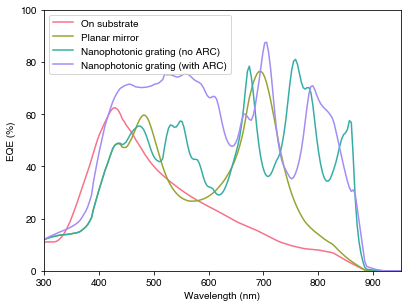

In [10]:

pal = sns.color_palette("husl", 4)

fig = plt.figure(figsize=(6.4, 4.8))

plt.plot(wavelengths*1e9, 100*Abs_onsubs, color=pal[0], label="On substrate")
plt.plot(wavelengths*1e9, 100*Abs_TMM, color=pal[1], label="Planar mirror")
plt.plot(wavelengths*1e9, 100*Abs_DTL, color=pal[2], label="Nanophotonic grating (no ARC)")
plt.plot(wavelengths*1e9, 100*Abs_DTL_ARC, color=pal[3], label="Nanophotonic grating (with ARC)")

plt.xlim(300, 950)
plt.ylim(0, 100)
plt.xlabel('Wavelength (nm)')
plt.ylabel('EQE (%)')
plt.legend(loc='upper left')
plt.show()

We see that the addition of a planar silver mirror significantly boosts the absorption around 700 nm, essentially by creating a Fabry-Perot (thin film) cavity in the semiconductor layers through high reflection at the rear of the cell. The grating introduces multiple resonances relating to different diffraction orders and waveguide modes in the structure, which boosts the absorption especially close to the absorption edge in comparison to the planar devices.

**PLOT 2**: Absorption per layer in the planar Ag device.

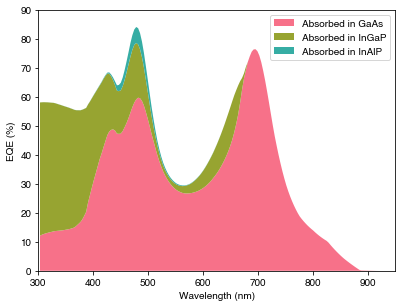

In [11]:
fig = plt.figure(figsize=(6.4, 4.8))
plt.stackplot(wavelengths*1e9,
              [100*Abs_TMM, 100*Abs_TMM_InGaPonly, 100*Abs_TMM_InAlPonly],
              colors=pal,
              labels=['Absorbed in GaAs', 'Absorbed in InGaP', 'Absorbed in InAlP'])
plt.xlim(300, 950)
plt.ylim(0, 90)
plt.xlabel('Wavelength (nm)')
plt.ylabel('EQE (%)')
plt.legend(loc='upper right')
plt.show()

The plot above shows that at short wavelengths, even very thin layers (in this case, 20 nm of InGaP) can absorb a very significant fraction of the incident radiation. Depending on the device, the carriers generated here may or may not be extracted as current.

## Calculating photogenerated current

Finally, we use the photon flux in the AM0 spectrum to calculate the maximum possible achievable current for these devices.

In [12]:
onsubs = 0.1 * q * np.trapz(Abs_onsubs*AM0, wavelengths)
Ag = 0.1 * q * np.trapz(Abs_TMM*AM0, wavelengths)
DTL = 0.1 * q * np.trapz(Abs_DTL*AM0, wavelengths)
DTL_ARC = 0.1 * q * np.trapz(Abs_DTL_ARC*AM0, wavelengths)


print('On substrate device current: %.1f mA/cm2 ' % onsubs)
print('Planar Ag mirror device current: %.1f mA/cm2 ' % Ag)
print('Nanophotonic grating (no ARC) device current: %.1f mA/cm2 ' % DTL)
print('Nanophotonic grating (with ARC) device current: %.1f mA/cm2 ' % DTL_ARC)

On substrate device current: 9.5 mA/cm2 
Planar Ag mirror device current: 13.8 mA/cm2 
Nanophotonic grating (no ARC) device current: 18.0 mA/cm2 
Nanophotonic grating (with ARC) device current: 23.0 mA/cm2 


As expected, simply adding a planar mirror boosts the current significantly. The addition of a nanophotonic grating gives a further boost (note that the grating we used here is optimized in terms of grating pitch (period) and dimension; not all gratings would give a boost in current, and some may even reduce performance due to e.g. parasitic absorption).